In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# data importing
mnist = fetch_openml('mnist_784')

In [3]:
#data split as data and target and scaling
X = mnist['data']
Y = mnist['target']
X = X/255

# one hot encoding of the labels

number_digits = 10
number_examples = Y.shape[0]

Y = Y.reshape(1, number_examples)
Y_new = np.eye(number_digits)[Y.astype('int32')]
Y_new = Y_new.T.reshape(number_digits, number_examples)

# train test split
number_train_sample = 60000
number_test_sample = X.shape[0] - number_train_sample

X_train, Y_train = X[:number_train_sample].T, Y_new[:,:number_train_sample]
X_test, Y_test = X[number_train_sample:].T, Y_new[:,number_train_sample:]


index = np.random.permutation(number_train_sample)
X_train = X_train[:,index]
Y_train = Y_train[:,index]

In [4]:
# necessary functions

def sigmoid(z):
    return (1/(1+np.exp(-z)))

def prime_sigmoid(z):
    return ((sigmoid(z)*(1-sigmoid(z))))

def softmax(z):
    return ((np.exp(z)/np.sum(np.exp(z), axis=0)))

def multiclass_cross_entropy(y, y_hat):
    m = y.shape[1]
    loss = (-1/m)*(np.sum(np.multiply(y, np.log(y_hat))))
    return loss

def Feedforward(X, params):
    
    forward_prop = {}
    forward_prop["Z1"] = np.matmul(params["W1"], X) + params["b1"]
    forward_prop["A1"] = sigmoid(forward_prop["Z1"])
    forward_prop["Z2"] = np.matmul(params["W2"], forward_prop["A1"]) + params["b2"]
    forward_prop["A2"] = softmax(forward_prop["Z2"])
    
    return forward_prop

def Backpropagation(X, Y, params, forward_prop, bs):
    
    dZ2 = forward_prop["A2"] - Y
    dW2 = (1/bs)*np.matmul(dZ2, forward_prop["A1"].T)
    db2 = (1/bs)*(np.sum(dZ2))
    
    dA1 = np.matmul(params["W2"].T, dZ2)
    dZ1 = dA1 * prime_sigmoid(forward_prop["Z1"])
    dW1 = (1/bs)*np.matmul(dZ1, X.T)
    db1 = (1/bs)*np.sum(dZ1)
    
    gradients = {"dW1": dW1,
                 "db1": db1,
                 "dW2": dW2,
                 "db2": db2}
    return gradients

In [11]:
def network_model(learning_rate):

    np.random.seed(138)

    # defining hyper parameters
    number_inputlayers = X_train.shape[0]
    number_hiddenlayers = 100
    # learning_rate = 8
    beta = 0.9
    number_batches = 128
    batches = -(-number_train_sample // number_batches)
    ilist = []
    trl = []
    tel = []
    #initialiation of weights and biases
    #shrink the variance of the weights in each layer for initialization and
    #it is done by divinding the parameters by np.sqrt(n)
    #- n:number_inputlayers for input layer and n:number_hiddenlayer for hidden layer

    parameters = {"W1": (np.random.randn(number_hiddenlayers, number_inputlayers) * np.sqrt(1/number_inputlayers)),
                  "b1": (np.zeros((number_hiddenlayers, 1)) * np.sqrt(1/number_inputlayers)),
                  "W2": (np.random.randn(number_digits, number_hiddenlayers) * np.sqrt(1/number_hiddenlayers)),
                  "b2": (np.zeros((number_digits, 1)) * np.sqrt(1/number_hiddenlayers))}

    #initialization for momentum variables

    momentum_dW1 = np.zeros(parameters["W1"].shape)
    momentum_db1 = np.zeros(parameters["b1"].shape)
    momentum_dW2 = np.zeros(parameters["W2"].shape)
    momentum_db2 = np.zeros(parameters["b2"].shape)

    # training the network model
    for i in range(9):

        #shuffling the training sets
        index_shuffle = np.random.permutation(X_train.shape[1])
        X_train_sh = X_train[:,index_shuffle]
        Y_train_sh = Y_train[:,index_shuffle]

        for j in range(batches):

            # defining start and end of the batch
            start = j * number_batches
            end = min(start + number_batches, X_train.shape[1] - 1)
            X = X_train_sh[:, start:end]
            Y = Y_train_sh[:, start:end]
            batch_size = end - start

            forward_prop = Feedforward(X, parameters)
            gradiants = Backpropagation(X, Y, parameters, forward_prop, batch_size)

            # introducing momentum
            momentum_dW1 = (beta * momentum_dW1) + (1-beta)*gradiants["dW1"]
            momentum_db1 = (beta * momentum_db1) + (1-beta)*gradiants["db1"]
            momentum_dW2 = (beta * momentum_dW2) + (1-beta)*gradiants["dW2"]
            momentum_db2 = (beta * momentum_db2) + (1-beta)*gradiants["db2"]

            # updating gradients
            parameters["W1"] = parameters["W1"] - learning_rate * momentum_dW1
            parameters["b1"] = parameters["b1"] - learning_rate * momentum_db1
            parameters["W2"] = parameters["W2"] - learning_rate * momentum_dW2
            parameters["b2"] = parameters["b2"] - learning_rate * momentum_db2

        forward_prop = Feedforward(X_train, parameters)
        training_loss = multiclass_cross_entropy(Y_train, forward_prop["A2"])
        testing = Feedforward(X_test, parameters)
        testing_loss = multiclass_cross_entropy(Y_test, testing["A2"])
    #     plt.plot(range(i,i+1), training_loss,color='green',linewidth=2, markersize=12)
    #     plt.plot(range(i,i+1), testing_loss,color='red',linewidth=2, markersize=12)
        print("Epoch {}: training_loss = {}, testing_loss = {}".format(i+1 ,training_loss, testing_loss))
        ilist.append(i)
        trl.append(training_loss)
        tel.append(testing_loss)
    
    a = "learning rate" + str(learning_rate)
    plt.title(a)
    plt.plot(ilist, trl,color='green',linewidth=2, markersize=12, label='training_loss')
    plt.plot(ilist, tel,color='red',linewidth=2, markersize=12, label='testing_loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
    feed_forward = Feedforward(X_test, parameters)
    predictions = np.argmax(feed_forward["A2"], axis=0)
    labels = np.argmax(Y_test, axis=0)

    print(confusion_matrix(predictions, labels))
    print(classification_report(predictions, labels))


**----------------**
For learning rate:  0.01
Epoch 1: training_loss = 1.952667387098876, testing_loss = 1.9445892075133857
Epoch 2: training_loss = 1.5833470330251962, testing_loss = 1.5693885061041917
Epoch 3: training_loss = 1.2651924530436627, testing_loss = 1.2480977326765674
Epoch 4: training_loss = 1.0399657902853077, testing_loss = 1.0217713902085652
Epoch 5: training_loss = 0.8876552302457239, testing_loss = 0.8690440323403147
Epoch 6: training_loss = 0.7821542708245145, testing_loss = 0.7637264839971698
Epoch 7: training_loss = 0.7060274580209528, testing_loss = 0.6874996056764492
Epoch 8: training_loss = 0.6486222153004628, testing_loss = 0.6301123392397467
Epoch 9: training_loss = 0.6039572549940654, testing_loss = 0.5855958051457627


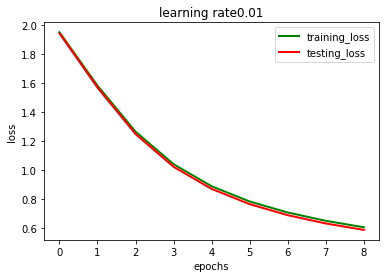

[[ 950    0   17    4    2   20   21    4   15   12]
 [   0 1100   27    3   10   15    6   38   22   13]
 [   4    6  855   23    5    7   23   21   16   11]
 [   1    5   23  881    0   84    2    1   52   10]
 [   0    0   22    1  855   22   11    7   15   69]
 [  12    1    1   35    2  670   21    2   29   14]
 [  10    4   25    8   17   26  873    0   16    1]
 [   1    0   21   23    2   12    0  901   14   41]
 [   2   19   39   26    5   27    1    9  771    6]
 [   0    0    2    6   84    9    0   45   24  832]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1045
           1       0.97      0.89      0.93      1234
           2       0.83      0.88      0.85       971
           3       0.87      0.83      0.85      1059
           4       0.87      0.85      0.86      1002
           5       0.75      0.85      0.80       787
           6       0.91      0.89      0.90       980
           7       0.88      0.89   

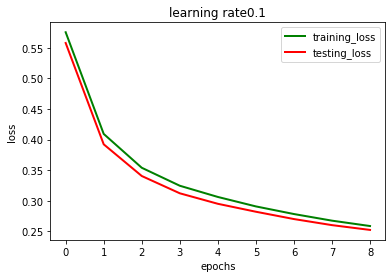

[[ 964    0   10    2    1    9   12    2    8   12]
 [   0 1112    7    1    3    3    3    9    8    7]
 [   3    2  928   20    4    3    5   21    5    1]
 [   2    2   16  929    0   41    1    5   23   11]
 [   0    0   11    0  912    7   10    5    9   28]
 [   3    2    2   24    1  784   16    0   31    7]
 [   6    4   12    2   10   11  907    0   11    0]
 [   1    2   13   13    2    5    2  954   11   17]
 [   1   11   27   10    4   21    2    3  857    4]
 [   0    0    6    9   45    8    0   29   11  922]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1020
           1       0.98      0.96      0.97      1153
           2       0.90      0.94      0.92       992
           3       0.92      0.90      0.91      1030
           4       0.93      0.93      0.93       982
           5       0.88      0.90      0.89       870
           6       0.95      0.94      0.94       963
           7       0.93      0.94   

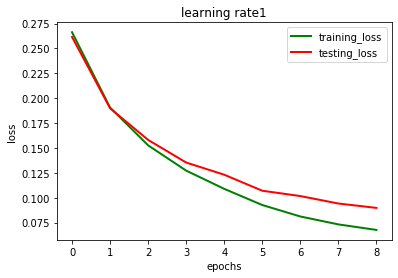

[[ 965    0    6    1    2    3    7    1    6    3]
 [   0 1122    4    0    0    1    3    6    1    6]
 [   1    3 1004    2    2    0    1   11    1    0]
 [   1    1    2  975    1    3    0    2    6    6]
 [   0    0    4    0  960    2    2    2    6   15]
 [   4    1    0   18    0  873    8    2    6    4]
 [   6    4    3    0    5    5  935    0    8    1]
 [   2    1    5    7    3    1    0  988    4    7]
 [   1    3    3    4    1    1    2    0  933    1]
 [   0    0    1    3    8    3    0   16    3  966]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       994
           1       0.99      0.98      0.99      1143
           2       0.97      0.98      0.98      1025
           3       0.97      0.98      0.97       997
           4       0.98      0.97      0.97       991
           5       0.98      0.95      0.97       916
           6       0.98      0.97      0.97       967
           7       0.96      0.97   

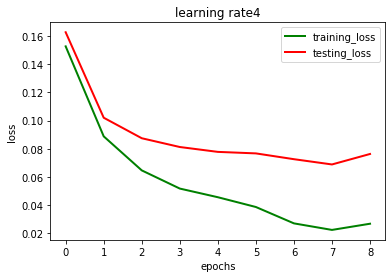

[[ 973    0    3    0    2    3    5    1    5    1]
 [   1 1120    2    0    0    0    3    4    2    2]
 [   2    3 1016   10    0    0    2    7    6    0]
 [   0    1    0  953    1    1    1    1    4    2]
 [   0    0    1    1  956    1    4    1    1    6]
 [   0    2    0   22    0  880    7    0    4    1]
 [   2    4    2    1    6    4  936    0    8    2]
 [   1    2    6    4    1    1    0 1005    6    2]
 [   1    3    2    3    0    1    0    0  933    0]
 [   0    0    0   16   16    1    0    9    5  993]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       993
           1       0.99      0.99      0.99      1134
           2       0.98      0.97      0.98      1046
           3       0.94      0.99      0.97       964
           4       0.97      0.98      0.98       971
           5       0.99      0.96      0.97       916
           6       0.98      0.97      0.97       965
           7       0.98      0.98   

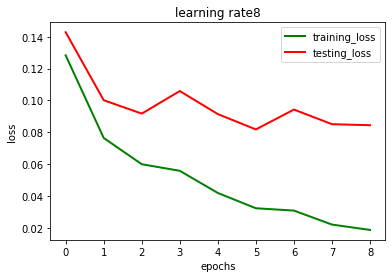

[[ 971    0    2    1    0    4    6    0    7    3]
 [   0 1119    0    0    0    0    2    3    0    2]
 [   3    2 1012    8    3    1    1   14    4    1]
 [   0    4    0  966    1    7    0    3    1    3]
 [   1    1    5    1  965    1   10    2    5   15]
 [   1    1    0   14    0  866    5    0    5    3]
 [   1    5    1    0    4    4  932    0    2    0]
 [   1    1    6    6    1    1    0  992    3    1]
 [   2    2    3    3    1    3    2    1  943    2]
 [   0    0    3   11    7    5    0   13    4  979]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       994
           1       0.99      0.99      0.99      1126
           2       0.98      0.96      0.97      1049
           3       0.96      0.98      0.97       985
           4       0.98      0.96      0.97      1006
           5       0.97      0.97      0.97       895
           6       0.97      0.98      0.98       949
           7       0.96      0.98   

In [14]:
learning_rates = [0.01, 0.1, 1, 4, 8]

for learning_rate in learning_rates:
    print("**----------------**")
    print("For learning rate: ", learning_rate)
    network_model(learning_rate)